In [ ]:
import numpy as np
import random
%matplotlib inline
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation

In [14]:
class Trader:
    """Represents a single trader on the grid."""  
    BUYER, INACTIVE, SELLER = 1, 0, -1 
    def __init__(self):
        self.state = self.INACTIVE

    def activate(self, new_state: int):
        self.state = new_state
    
    def deactivate(self):
        self.state = self.INACTIVE


In [167]:
class Market:
    """Represents a grid of traders."""
    def __init__(self, width: int, height: int):
        self.width = width
        self.height = height
        self.grid = np.array([[Trader() for _ in range(width)] for _ in range(height)])

    def get_neighbors(self, x: int, y: int):
        """Get the neighbors of a cell at position (x, y) based on Von Neumann neighborhood."""
        neumann_directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        return [
            ((x + dx) % self.height, (y + dy) % self.width)
            for dx, dy in neumann_directions
        ]

    def retrieve_trader_states(self):
        """Retrieve the current states of all traders in a grid."""
        return np.array([[trader.state for trader in row] for row in self.grid])

    def random_activation(self, p: float):
        """Randomly activate a fraction p of traders in the grid."""
        BUYER, SELLER = 1, -1
        num_active_traders = int(p * self.width * self.height)

        r_idx = np.random.randint(0, self.height, num_active_traders)
        c_idx = np.random.randint(0, self.width, num_active_traders)

        for r, c in zip(r_idx, c_idx):
            self.grid[r, c].activate(np.random.choice([BUYER, SELLER]))

    def update_market(self, dynamics):
        """Update the market for a single time step using dynamics."""
        trader_states = self.retrieve_trader_states()
        new_states = np.copy(trader_states)
        updates = []

        for x, row in enumerate(self.grid):
            for y, trader in enumerate(row):
                updates.extend(dynamics.trader_update(self.grid, x, y))

        for x, y, new_state in updates:
            new_states[x, y] = new_state

        # Apply all updates at once
        for x, y, new_state in updates:
            self.grid[x][y].state = new_state



    

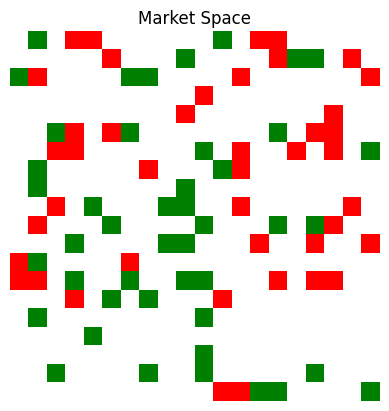

0.22

In [50]:
t1 = Trader()
m1 = Market(20, 20)

m1.grid[0,1].activate(1)

m1.get_neighbors(0,1)

m1.random_activation(0.25)
state_matrix = m1.retrieve_trader_states()
cmap = mcolors.ListedColormap(['red', 'white', 'green'])
bounds = [-1, 0, 1, 2]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plotting the grid
plt.imshow(state_matrix, cmap=cmap, norm=norm)
plt.title("Market Space")
plt.axis('off')
plt.show()

sum(sum(abs(state_matrix))) / (20 *20)

In [ ]:

class PercolationDynamics:
    def __init__(self, market, ph: float, pe: float, pd: float):
        self.ph = ph
        self.pe = pe
        self.pd = pd
        self.market = market

    def trader_update(self, grid, x: int, y: int):
        """
        Determine the state updates for a trader at position (x, y).
        Returns a list of updates [(x, y, new_state)].
        """
        BUYER, INACTIVE, SELLER = 1, 0, -1
        updates = []

        trader = grid[x][y]
        if trader.state == INACTIVE:
            if np.random.random() < self.pe:
                updates.append((x, y, np.random.choice([BUYER, SELLER])))
        else:
            neighbors = self.market.get_neighbors(x, y)
            inactive_neighbors = [
                (nx, ny) for nx, ny in neighbors if grid[nx][ny].state == INACTIVE
            ]

            # Activate inactive neighbors
            for nx, ny in inactive_neighbors:
                if np.random.random() < self.ph:
                    updates.append((nx, ny, np.random.choice([BUYER, SELLER])))

            # Chance to turn inactive
            if np.random.random() < self.pd * len(inactive_neighbors):
                updates.append((x, y, INACTIVE))

        return updates

    def apply_updates(self, grid, updates):
        """
        Apply state updates to the grid.
        """
        for x, y, new_state in updates:
            grid[x][y].state = new_state

    def time_step(self):
        """
        Perform a single time step, updating the market grid.
        """
        updates = []

        # Collect updates from each trader
        for x in range(len(self.market.grid)):
            for y in range(len(self.market.grid[0])):
                updates.extend(self.trader_update(self.market.grid, x, y))

        # Apply all updates
        self.apply_updates(self.market.grid, updates)

        


In [168]:
def animate_market(market, dynamics, num_steps=100):
    # Initialize the grid states for animation
    grid_states = []

    # Set up the figure and axes for grid and line plots
    fig, (ax, ax_line) = plt.subplots(2, 1, figsize=(8, 12))

    # Initialize grid plot
    grid_plot = ax.imshow(
        np.zeros((market.height, market.width)), cmap="coolwarm", vmin=-1, vmax=1
    )
    ax.set_title("Cellular Automata (Grid)")
    ax.axis("off")

    # Set up the line plot for tracking buyers, sellers, and total participants
    buyers_line, = ax_line.plot([], [], label="Buyers (1)", color="blue")
    sellers_line, = ax_line.plot([], [], label="Sellers (-1)", color="red")
    total_line, = ax_line.plot([], [], label="Total Participants", color="green")

    ax_line.set_title("Market Participation Over Time")
    ax_line.set_xlim(0, num_steps)
    ax_line.set_ylim(0, market.width * market.height)  # Max total participants
    ax_line.set_xlabel("Steps")
    ax_line.set_ylabel("Count")
    ax_line.legend()

    # Arrays to store counts over time
    buyers_counts = []
    sellers_counts = []
    total_counts = []

    def update(frame):
        """Update function for each animation frame."""
        # Perform one step of the dynamics
        dynamics.time_step()

        # Capture grid state
        grid_state = market.retrieve_trader_states()
        grid_states.append(grid_state)

        # Update grid plot
        grid_plot.set_array(grid_state)

        # Count the number of buyers, sellers, and total participants
        buyers_count = np.sum(grid_state == 1)
        sellers_count = np.sum(grid_state == -1)
        total_count = buyers_count + sellers_count

        buyers_counts.append(buyers_count)
        sellers_counts.append(sellers_count)
        total_counts.append(total_count)

        # Update the line plot
        buyers_line.set_data(range(frame + 1), buyers_counts)
        sellers_line.set_data(range(frame + 1), sellers_counts)
        total_line.set_data(range(frame + 1), total_counts)

        # Dynamically adjust the y-axis limits for better visualization
        max_count = max(max(buyers_counts), max(sellers_counts), max(total_counts))
        ax_line.set_ylim(0, max(max_count, 1.1 * (market.width * market.height)))

        return grid_plot, buyers_line, sellers_line, total_line

    # Create the animation
    ani = FuncAnimation(fig, update, frames=num_steps, interval=200, blit=False)

    # Display the animation in the notebook
    plt.close(fig)  # Prevent duplicate static figures in notebooks
    return HTML(ani.to_html5_video())



In [169]:
pd = 0.05
pe = 0.001
ph = 0.0485
width, height = 20, 20
market = Market(width, height)
dynamics = PercolationDynamics(market, ph=ph, pd=pd, pe=pe)
animate_market(market, dynamics)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (3,).

In [143]:
m1.grid[0,1].state == 0

False

[(0, 1), (2, 1), (1, 0), (1, 2)]
3


array([[ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0

In [ ]:
m1 = Market(20, 20)

pDyn = PercolationDynamics(m1, 0.1, 0.1, 0.1)
pDyn.time_step(m1.grid)